# Time series analysis of provinces and territories

* This is essentially EDA, not part of ML framework, despite the file name
* The second section can be repeated with different weight_cols or province_cols
* requires a csv file in the same folder named 'down_up_lat_tests_by_quarter.csv'
* Total runtime of ten seconds

## Library imports and read data

In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt 
import sys

In [2]:
time_data = pd.DataFrame()
number_of_chunks = 5
for idx in range(1, number_of_chunks+1):
    time_data = pd.concat([time_data, pd.read_csv(f"down_up_lat_tests_by_quarter_part{idx}.csv")]);

In [3]:
down_cols = [col for col in time_data if col.startswith('d20')]
up_cols = [col for col in time_data if col.startswith('u20')]
lat_cols = [col for col in time_data if col.startswith('l20')]
tests_cols = [col for col in time_data if col.startswith('t20')]

In [4]:
def weighted_mean(df, feature_cols, scale, weight_cols=None):
    
    if weight_cols==None:
        result=pd.DataFrame({'PRNAME':time_data['PRNAME'].unique()})
        result = result.merge(df.loc[:, ['PRNAME'] + feature_cols].groupby(['PRNAME']).mean()/scale, on='PRNAME')
        return result
    
    else:
        product=pd.DataFrame()
        product['PRNAME'] = df['PRNAME']
        result=pd.DataFrame({'PRNAME':time_data['PRNAME'].unique()})
        for i in range(len(feature_cols)):
            product[feature_cols[i]] = df[feature_cols[i]] * df[weight_cols[i]]
            numerator = product.loc[:, ['PRNAME'] + [feature_cols[i]]].groupby(['PRNAME']).sum()
            denominator = df.loc[:, ['PRNAME'] + [weight_cols[i]]].groupby(['PRNAME']).sum()
            weighted = numerator[feature_cols[i]]/denominator[weight_cols[i]]
            #result[feature_cols[i]] = weighted.values/1000
            result = result.merge(pd.Series(weighted/scale, name=feature_cols[i]), on='PRNAME')
        return result
    
def PRNAME_rename(df):
    return df.rename(columns={'Alberta':'AB', 'British Columbia / Colombie-Britannique':'BC', 'Manitoba':'MB',
       'New Brunswick / Nouveau-Brunswick':'NB',
       'Newfoundland and Labrador / Terre-Neuve-et-Labrador':'NL',
       'Northwest Territories / Territoires du Nord-Ouest':'NT',
       'Nova Scotia / Nouvelle-Écosse':'NS',  'Nunavut':'NU', 'Ontario':'ON',
       'Prince Edward Island / Île-du-Prince-Édouard':'PE', 'Quebec / Québec':'QC',
       'Saskatchewan':'SK', 'Yukon':'YT'})
    

## Average the provincial data and plot

In [5]:
#Make weight_cols None for unweighted averaging and tests_cols for weighted by tests
weight_cols = None
#weight_cols = tests_cols

province_down_data = weighted_mean(time_data, down_cols, 1000, weight_cols).set_index('PRNAME').T
province_up_data = weighted_mean(time_data, up_cols, 1000, weight_cols).set_index('PRNAME').T
province_lat_data = weighted_mean(time_data, lat_cols, 1, weight_cols).set_index('PRNAME').T

In [6]:
province_down_data = PRNAME_rename(province_down_data)
province_up_data = PRNAME_rename(province_up_data)
province_lat_data = PRNAME_rename(province_lat_data)

province_down_data.index = province_down_data.index.str[1:]
province_up_data.index = province_up_data.index.str[1:]
province_lat_data.index = province_lat_data.index.str[1:]

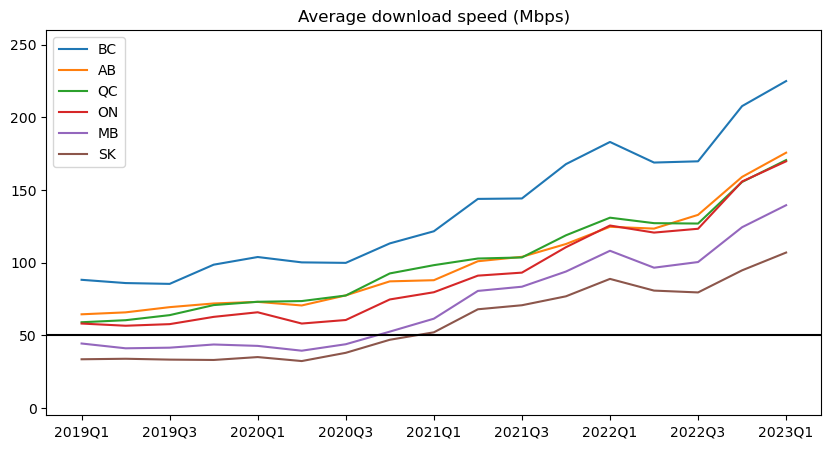

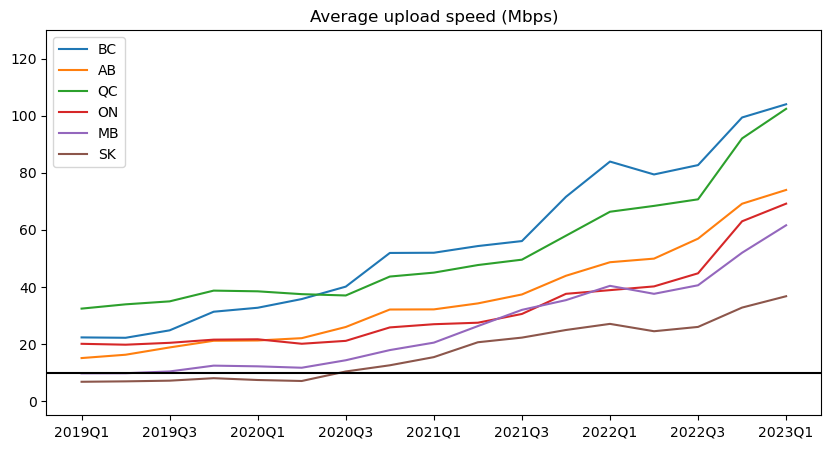

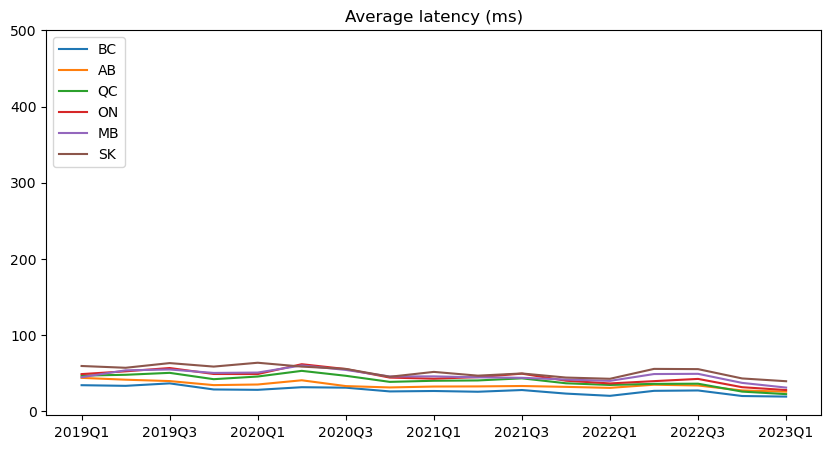

In [7]:
#province_cols = ['AB', 'BC', 'MB', 'NB', 'NL', 'NT', 'NU', 'NS', 'ON', 'PE', 'QC', 'SK', 'YT']
province_cols = ['BC', 'AB', 'QC', 'ON', 'MB', 'SK']

ax = province_down_data[province_cols].plot(figsize=(10,5))
ax.axhline(50, color='k')
plt.ylim(-5, 260)
plt.title("Average download speed (Mbps)")
plt.legend(loc='upper left')
plt.show()

ax = province_up_data[province_cols].plot(figsize=(10,5))
ax.axhline(10, color='k')
plt.ylim(-5, 130)
plt.title("Average upload speed (Mbps)")
plt.legend(loc='upper left')
plt.show()


ax = province_lat_data[province_cols].plot(figsize=(10,5))
plt.ylim(-5, 500)
plt.title("Average latency (ms)")
plt.legend(loc='upper left')
plt.show()

## Nunavut is an outlier. Why?

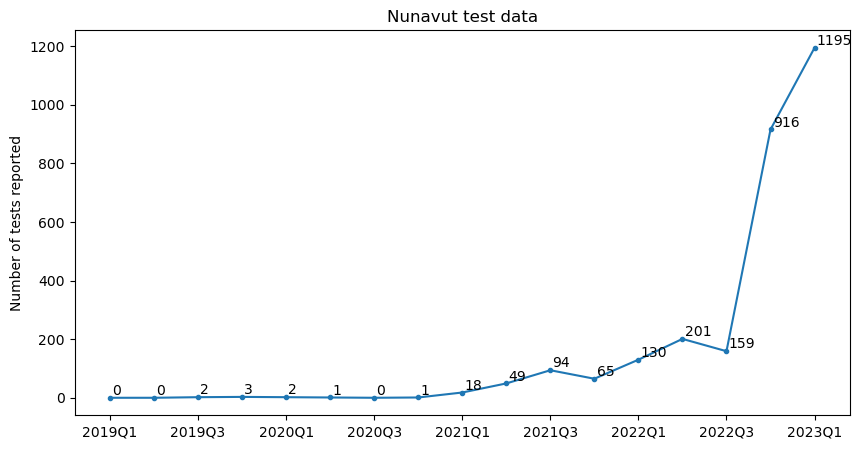

In [8]:
#ax = time_data[time_data['PRNAME']=='Nunavut'].loc[:, down_cols].describe().loc['count'].plot(figsize=(10,5), style='*-')
series = time_data[tests_cols][time_data['PRNAME']=='Nunavut'].sum()
series.index = series.index.str[1:]
ax = series.plot(figsize=(10,5), style='.-')
ax.set_ylabel("Number of tests reported")
ax.set_title("Nunavut test data")
#ax.axhline(0, color='k')

def label_point(x, y, val, ax):
    for i in range(len(x)):
        ax.text(x[i]+0.05, y[i]+10, int(val[i]))
label_point(range(len(series.index)), series.values, series.values, ax)